# SNN on BioTac Data

Here we implement autoencoder:

loss = loss_classification + loss_regression

In [22]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [23]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tas_utils import get_trainValLoader, get_testLoader

np.random.seed(1)
torch.manual_seed(1)

### upload data

In [24]:
data_dir = '../../new_data_folder/'
logDir = 'models_and_stats/'
kfold_number = 0

model_name = 'semisupervised_both_' + str(kfold_number)
screen_fr = 50

save_dir = logDir + model_name + '.pt'

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=0)
test_loader, test_dataset = get_testLoader(data_dir)

In [25]:
save_dir_total

'models_and_stats/semisupervised_both_0total.pt'

### define spike neuron

In [26]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1},
    "training": {
        "error": {
            "type": "SpikeTime",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 75,
            },
            "tgtSpikeCount": {True: 60, False: 10},
        }
    },
}

In [27]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1, hidden_size2):
        super(SlayerMLP, self).__init__()
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        
        self.fc_decoder1 = self.slayer.dense(hidden_size2, hidden_size1)
        self.fc_decoder2 = self.slayer.dense(hidden_size1, input_size)

    def get_spike(self, inp):
        return self.slayer.spike(inp)
    
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        
        spike_hat1 = self.slayer.spike(self.slayer.psp(self.fc_decoder1(spike_2)))
        spike_hat2 = self.slayer.spike(self.slayer.psp(self.fc_decoder2(spike_hat1)))
        
        return spike_2, spike_hat2

In [34]:
device = torch.device("cuda:2")
net_icub = SlayerMLP(params, 60, 50, 50).to(device)
net_bio = SlayerMLP(params, 19, 50, 50).to(device)

In [35]:
error = snn.loss(params).to(device)
optimizer_icub = torch.optim.RMSprop(net_icub.parameters(), lr=0.001, weight_decay=0.5)
optimizer_bio = torch.optim.RMSprop(net_bio.parameters(), lr=0.01, weight_decay=0.5)

In [36]:
train_total_losses=[]
train_regres_icub_losses=[]
train_regres_bio_losses=[]
train_regres_bt_losses=[]

val_total_losses=[]
val_regres_icub_losses=[]
val_regres_bio_losses=[]
val_regres_bt_losses=[]


beta1 = 1 #0.001 icub
beta2 = 1 #0.001 bio
beta3 = 1 #0.001 betweem

min_val_loss_icub = 1e9
min_val_loss_bio = 1e9

min_between_loss = 1e9
min_total_loss = 1e9

for epoch in range(30001):
    net_icub.train()
    net_bio.train()
    loss_train = 0
    loss_reg_icub = 0
    loss_reg_bio = 0
    loss_reg_between = 0
    for i, (tact_icub, tact_bio,  target, label) in enumerate(train_loader):
        
        tact_bio = tact_bio.to(device)
        tact_bio = tact_bio[...,::2]
        tact_icub = tact_icub.to(device)
        
        target = target.to(device)
        tact_bio = net_bio.get_spike(tact_bio)
        tact_icub = net_icub.get_spike(tact_icub)
        
        icub_rep, out_icub = net_icub.forward(tact_icub)
        bio_rep, out_bio = net_bio.forward(tact_bio)
                
        loss_reg_icub_ = beta1*error.spikeTime(tact_icub, out_icub)
        loss_reg_bio_ = beta2*error.spikeTime(tact_bio, out_bio)
        loss_reg_between_ = beta3*error.spikeTime(icub_rep, bio_rep)
        
        loss = loss_reg_icub_ + loss_reg_bio_ + loss_reg_between_
        
        loss_train += loss.item()
        loss_reg_icub += loss_reg_icub_.item()
        loss_reg_bio += loss_reg_bio_.item()
        loss_reg_between += loss_reg_between_.item()
        
        optimizer_icub.zero_grad()
        optimizer_bio.zero_grad()
        loss.backward()
        optimizer_icub.step()
        optimizer_bio.step()
                
    if epoch%screen_fr == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss (total, icub, bio, between):', 
              loss_train/len(train_dataset),
              loss_reg_icub/len(train_dataset),
              loss_reg_bio/len(train_dataset),
              loss_reg_between/len(train_dataset))
    train_total_losses.append(loss_train/len(train_dataset))
    train_regres_icub_losses.append(loss_reg_icub/len(train_dataset))
    train_regres_bio_losses.append(loss_reg_bio/len(train_dataset))
    train_regres_bt_losses.append(loss_reg_between/len(train_dataset))
    
    net_icub.eval()
    net_bio.eval()
    loss_val = 0
    loss_reg_icub = 0
    loss_reg_bio = 0
    loss_reg_between = 0
    with torch.no_grad():
        for i, (tact_icub, tact_bio,  target, label) in enumerate(val_loader):

            tact_bio = tact_bio.to(device)
            tact_bio = tact_bio[...,::2]
            tact_icub = tact_icub.to(device)

            target = target.to(device)
            tact_bio = net_bio.get_spike(tact_bio)
            tact_icub = net_icub.get_spike(tact_icub)

            icub_rep, out_icub = net_icub.forward(tact_icub)
            bio_rep, out_bio = net_bio.forward(tact_bio)

            loss_reg_icub_ = beta1*error.spikeTime(tact_icub, out_icub)
            loss_reg_bio_ = beta2*error.spikeTime(tact_bio, out_bio)
            loss_reg_between_ = beta3*error.spikeTime(icub_rep, bio_rep)

            loss = loss_reg_icub_ + loss_reg_bio_ + loss_reg_between_

            loss_val += loss.item()
            loss_reg_icub += loss_reg_icub_.item()
            loss_reg_bio += loss_reg_bio_.item()
            loss_reg_between += loss_reg_between_.item()
            
    if epoch%screen_fr == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Val loss (total, icub, bio, between):', 
              loss_val/len(val_dataset),
              loss_reg_icub/len(val_dataset),
              loss_reg_bio/len(val_dataset),
              loss_reg_between/len(val_dataset))
    val_total_losses.append(loss_val/len(val_dataset))
    val_regres_icub_losses.append(loss_reg_icub/len(val_dataset))
    val_regres_bio_losses.append(loss_reg_bio/len(val_dataset))
    val_regres_bt_losses.append(loss_reg_between/len(val_dataset))
    
    # save icub model based on val loss
    if (loss_reg_icub/len(val_dataset) <= min_val_loss_icub) & (epoch%100 == 0):
        print('Saving icub model at ', epoch, ' epoch')
        min_val_loss_icub = loss_reg_icub/len(val_dataset)
        torch.save(net_icub.state_dict(), logDir + model_name + '_icub.pt')
        
    # save bio model on val loss
    if (loss_reg_bio/len(val_dataset) <= min_val_loss_bio) & (epoch%100 == 0):
        print('Saving bio model at ', epoch, ' epoch')
        min_val_loss_bio = loss_reg_bio/len(val_dataset)
        torch.save(net_bio.state_dict(), logDir + model_name + '_bio.pt')
        
    # save bio, icub models on total loss
    if (loss_val/len(val_dataset) <= min_total_loss) & (epoch%100 == 0):
        print('Saving bio model at ', epoch, ' epoch')
        min_total_loss = loss_val/len(val_dataset)
        torch.save(net_icub.state_dict(), logDir + model_name + '_total_icub.pt')
        torch.save(net_bio.state_dict(), logDir + model_name + '_total_bio.pt')
        
    # save bio, icub models on shared loss
    if (loss_reg_between/len(val_dataset) <= min_between_loss) & (epoch%100 == 0):
        print('Saving bio model at ', epoch, ' epoch')
        min_between_loss = loss_reg_between/len(val_dataset)
        torch.save(net_icub.state_dict(), logDir + model_name + '_shared_icub.pt')
        torch.save(net_bio.state_dict(), logDir + model_name + '_shaerd_bio.pt')

Epoch:  0  --------------------------
Train loss (total, icub, bio, between): 85595.09901041667 16479.395950520833 12399.878450520833 56715.82484375
Epoch:  0  --------------------------
Val loss (total, icub, bio, between): 57339.60984375 13939.1671484375 8624.3759375 34776.066796875
Saving icub model at  0  epoch
Saving bio model at  0  epoch
Saving bio model at  0  epoch
Saving bio model at  0  epoch
Epoch:  50  --------------------------
Train loss (total, icub, bio, between): 19131.656067708333 5709.45138671875 3059.599622395833 10362.605091145833
Epoch:  50  --------------------------
Val loss (total, icub, bio, between): 18921.5092578125 5705.81005859375 3001.226220703125 10214.4726953125
Epoch:  100  --------------------------
Train loss (total, icub, bio, between): 13740.349166666667 3893.7038346354166 1922.8333235677082 7923.812057291667
Epoch:  100  --------------------------
Val loss (total, icub, bio, between): 14381.8641015625 4050.241376953125 2031.906484375 8299.7162109

Epoch:  1200  --------------------------
Train loss (total, icub, bio, between): 7773.023274739583 2071.2075032552084 1637.7193912760417 4064.0964192708334
Epoch:  1200  --------------------------
Val loss (total, icub, bio, between): 8706.2712109375 2633.0838427734375 1828.93025390625 4244.257177734375
Epoch:  1250  --------------------------
Train loss (total, icub, bio, between): 7851.163567708333 2068.6628515625 1627.1443343098958 4155.356416015625
Epoch:  1250  --------------------------
Val loss (total, icub, bio, between): 8717.1691015625 2579.43171875 1770.1996240234375 4367.537685546875
Epoch:  1300  --------------------------
Train loss (total, icub, bio, between): 7883.376946614583 2066.480222981771 1651.6146826171876 4165.2819921875
Epoch:  1300  --------------------------
Val loss (total, icub, bio, between): 8637.3484375 2628.3605126953125 1755.8814990234375 4253.106455078125
Saving bio model at  1300  epoch
Epoch:  1350  --------------------------
Train loss (total, icub

Epoch:  2550  --------------------------
Train loss (total, icub, bio, between): 7196.680963541667 1904.0226432291668 1507.5941878255207 3785.0641178385417
Epoch:  2550  --------------------------
Val loss (total, icub, bio, between): 8887.5041796875 2947.6931201171874 1666.69333984375 4273.117705078125
Epoch:  2600  --------------------------
Train loss (total, icub, bio, between): 7236.513209635416 1923.444580078125 1508.1579052734376 3804.9107421875
Epoch:  2600  --------------------------
Val loss (total, icub, bio, between): 8887.80732421875 2954.4703515625 1732.3912841796875 4200.94568359375
Epoch:  2650  --------------------------
Train loss (total, icub, bio, between): 7104.111946614584 1872.0000651041667 1514.2965462239583 3717.815341796875
Epoch:  2650  --------------------------
Val loss (total, icub, bio, between): 8591.1496484375 2895.17173828125 1711.544814453125 3984.432998046875
Epoch:  2700  --------------------------
Train loss (total, icub, bio, between): 7122.532408

Epoch:  3900  --------------------------
Train loss (total, icub, bio, between): 6541.284700520833 1684.6809928385417 1524.746671549479 3331.8570377604165
Epoch:  3900  --------------------------
Val loss (total, icub, bio, between): 8351.098203125 2844.800341796875 1708.257939453125 3798.0399609375
Saving bio model at  3900  epoch
Epoch:  3950  --------------------------
Train loss (total, icub, bio, between): 6639.4310091145835 1728.041572265625 1530.820458984375 3380.569013671875
Epoch:  3950  --------------------------
Val loss (total, icub, bio, between): 8332.41572265625 2783.7405517578127 1728.7765771484376 3819.898515625
Epoch:  4000  --------------------------
Train loss (total, icub, bio, between): 6595.858157552083 1716.2651497395834 1524.0390087890626 3355.553994140625
Epoch:  4000  --------------------------
Val loss (total, icub, bio, between): 8486.66158203125 2789.4382763671874 1939.8037939453125 3757.419541015625
Epoch:  4050  --------------------------
Train loss (tot

Epoch:  5200  --------------------------
Train loss (total, icub, bio, between): 6582.6829231770835 1798.1890250651043 1522.2534195963542 3262.2404622395834
Epoch:  5200  --------------------------
Val loss (total, icub, bio, between): 7754.3433984375 2484.010830078125 1677.5202587890626 3592.81232421875
Epoch:  5250  --------------------------
Train loss (total, icub, bio, between): 6567.249440104167 1730.6777799479166 1501.860634765625 3334.7110091145832
Epoch:  5250  --------------------------
Val loss (total, icub, bio, between): 8064.661796875 2624.0419580078124 1686.2296533203125 3754.390283203125
Epoch:  5300  --------------------------
Train loss (total, icub, bio, between): 6700.283111979166 1821.86328125 1481.2717106119792 3397.1481184895833
Epoch:  5300  --------------------------
Val loss (total, icub, bio, between): 8315.96376953125 2417.1193701171874 1737.7866845703124 4161.057724609375
Epoch:  5350  --------------------------
Train loss (total, icub, bio, between): 6698.

KeyboardInterrupt: 

In [37]:
# save stats
import pickle
all_stats = [
    train_total_losses,
    train_regres_icub_losses,
    train_regres_bio_losses,
    train_regres_bt_losses,
    val_total_losses,
    val_regres_icub_losses,
    val_regres_bio_losses,
    val_regres_bt_losses,
]

pickle.dump(all_stats, open(logDir + model_name + '_stats.pkl', 'wb'))

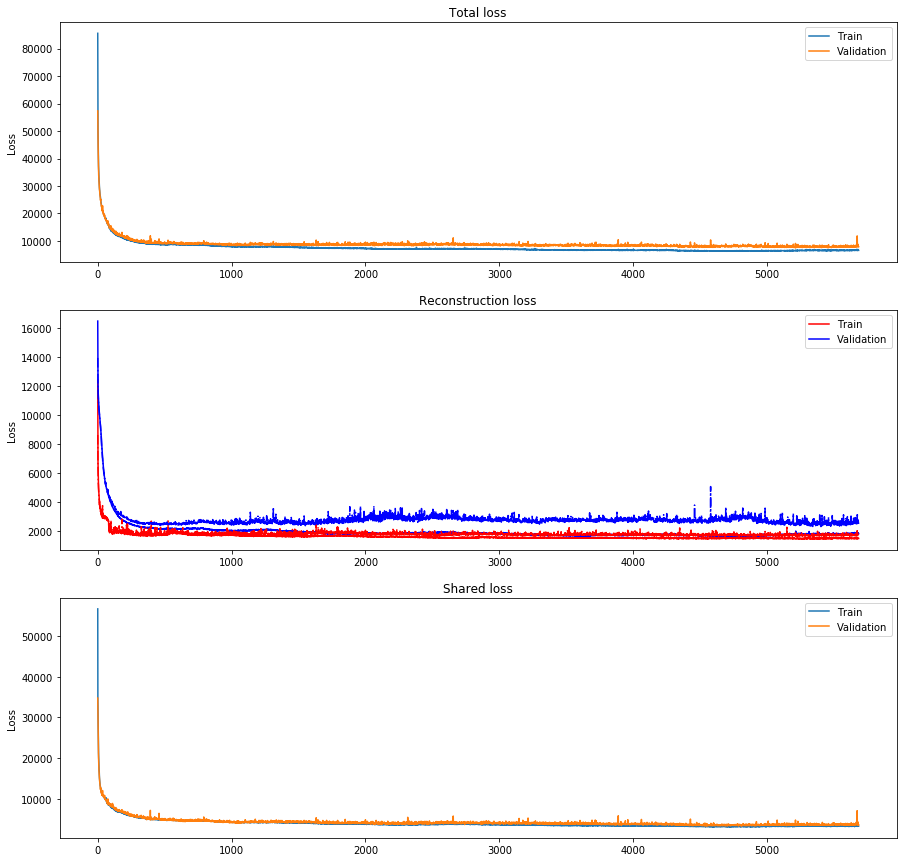

In [41]:
fig, ax = plt.subplots(3, figsize=(15,15))

ax[0].set_title('Total loss')
ax[0].plot(train_total_losses)
ax[0].plot(val_total_losses)
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Validation'])

ax[1].set_title('Reconstruction loss')
ax[1].plot(train_regres_bio_losses, 'r')
ax[1].plot(train_regres_icub_losses, 'b')
ax[1].plot(val_regres_bio_losses, 'r-.')
ax[1].plot(val_regres_icub_losses, 'b-.')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

ax[2].set_title('Shared loss')
ax[2].plot(train_regres_bt_losses)
ax[2].plot(val_regres_bt_losses)
ax[2].set_ylabel('Loss')
ax[2].legend(['Train', 'Validation'])


plt.show()